In [300]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

#list_names = ['User1', 'User3', 'User4', 'User5', 'User6', 'User7', 'User8']#, 'User7']
list_names = ['User3']#,'User4', 'User5', 'User6']#, 'User7']

nbUsers = len(list_names)

addword = '3s-PosClosest'

In [2]:
nbUsers

1

In [3]:
boneNames = []
bones = pd.Series()
bones = pd.read_csv('./BoneNames.csv')
bones = bones.transpose()
bones = bones.drop(bones.index[0])
for i in range(0, 19):
    boneNames.append('R-' + bones.iloc[0, i])
for i in range(0, 19):
    boneNames.append('L-' + bones.iloc[0, i])
    
for i in range(0, len(boneNames)):
    txt = boneNames[i]
    boneNames[i] = txt.replace('_CapsuleCollider', '')

In [4]:
word = '3s-Pos'
addword = 'Closest'

for user in range(0, nbUsers):
    date = list_names[user]
    analyseMe = pd.DataFrame()
    analyseMe = pd.read_csv('./Analysis/Positions/NoParam-'+addword+'G-0B-1.05-'+date+'-FullAnalysis-'+word+'.csv', sep = ';', low_memory = False)

    analyseMe['Tolerance'] = analyseMe['Unnamed: 0']
    del analyseMe['Unnamed: 0']

In [5]:
analyseMe.columns

Index(['Beta', 'Gamma', 'Contact.0', 'ContactL.0', 'Contact.1', 'ContactL.1',
       'Contact.2', 'ContactL.2', 'Contact.3', 'ContactL.3',
       ...
       'Pos.34.2580', 'PosPred.34.2580', 'ClosestPoint.34.2580', 'Pos.27.2900',
       'PosPred.27.2900', 'ClosestPoint.27.2900', 'Pos.30.2140',
       'PosPred.30.2140', 'ClosestPoint.30.2140', 'Tolerance'],
      dtype='object', length=42440)

In [6]:
for j in range(0, 19):
    analyseMe['Contact.'+str(j+19)] = analyseMe['ContactL.'+str(j)]

In [301]:
def progress(count, total, suffix=''):
    bar_len = 60
    filled_len = int(round(bar_len * count / float(total)))

    percents = round(100.0 * count / float(total), 1)
    bar = '=' * filled_len + '-' * (bar_len - filled_len)

    sys.stdout.write('[%s] %s%s ...%s\r' % (bar, percents, '%', suffix))
    sys.stdout.flush()  # As suggested by Rom Ruben

## Data Collection conditions

In [303]:
tasks = ['Touch', 'Raise', 'Pull', 'Push', 'Push Down']
objects = ['obj0', 'obj1', 'obj2', 'obj3', 'obj4', 'obj5', 'obj6', 'Cube', 'Cylinder']
scales = ['small', 'medium', 'large']

# Define Reach-to-Grasp Duration (mean/phal per config)

In [304]:
graspdurationdf = pd.DataFrame()
for config in range(0, 135):
    progress(config, 135)
    graspduration = pd.DataFrame()
    meanduration = 0
    nbduration = 0
    
    cond = analyseMe['Tolerance'] == config

    for scale in range(0, len(scales)):
        if((config < len(tasks)*len(objects)*(scale+1)) & (config >= len(tasks)*len(objects)*(scale))):
            taskToDo = tasks[config%len(tasks)]
            for obj in range(0, len(objects)):
                if((config < len(tasks)*(len(objects)*scale + obj+1)) & (config >= len(tasks)*(len(objects)*scale + obj))):
                    objToCatch = objects[obj]
            objScale = scales[scale]
    
    for j in range(0, 38):
        if((analyseMe['Contact.'+str(j)].loc[config] == 'True') | (analyseMe['Contact.'+str(j)].loc[config] == '1.0')):
            for k in range(0, 3050, 10):
                if('Pos.'+str(j)+'.'+str(k) in analyseMe[cond].columns):
                    
                    if(np.isnan(analyseMe['Pos.'+str(j)+'.'+str(k)].loc[config]) == False):
                        graspduration.loc[config, 'GraspDuration.'+str(j)] = analyseMe['Time.'+str(j)+'.'+str(k)].loc[config]
                        
            graspduration.loc[config, 'Task'] = taskToDo
            graspduration.loc[config, 'Obj'] = objToCatch
            graspduration.loc[config, 'Scale'] = objScale
                        
            meanduration = meanduration + graspduration['GraspDuration.'+str(j)].loc[config]
            nbduration = nbduration + 1
            
    if(nbduration != 0):
        graspduration.loc[config, 'MeanDuration'] = meanduration/nbduration
    else:
        pass
    
    graspdurationdf = pd.concat([graspdurationdf, graspduration], axis = 0, sort = True)
    
    
graspdurationdf.to_csv('./Analysis/GraspDuration/'+ date + addword +'.csv', sep = ';')
progress(100, 100)
print('\n')


# Go through all the data (each 10ms)
## All times when position/prediction/closest points were recorded. Define speeds, posToFinal, predToFinal, closToFinal.
## Times differ from one config to another. A second analysis is required.

In [311]:
summaryDifferences = pd.DataFrame()

for config in range(0, 135):
    progress(config, 135)
    differencesDf = pd.DataFrame()
    positionDf = pd.DataFrame()
    cond = analyseMe['Tolerance'] == config

    #differencesDf['User'] = list_names(user)
    for j in range(0, 38):
        if((analyseMe['Contact.'+str(j)].loc[config] == 'True') | (analyseMe['Contact.'+str(j)].loc[config] == '1.0')):
            for k in range(0, 3050, 10):
                if('Pos.'+str(j)+'.'+str(k) in analyseMe[cond].columns):
                    
                    if(np.isnan(analyseMe['Pos.'+str(j)+'.'+str(k)].loc[config]) == False):
                        positionDf.loc[k, 'Position.'+str(j)] = analyseMe['Pos.'+str(j)+'.'+str(k)].loc[config]
                        positionDf.loc[k, 'Time.'+str(j)] = analyseMe['Time.'+str(j)+'.'+str(k)].loc[config]

                        positionDf.loc[k, 'PosPred.'+str(j)] = analyseMe['PosPred.'+str(j)+'.'+str(k)].loc[config]
                        positionDf.loc[k, 'ClosestPoint.'+str(j)] = analyseMe['ClosestPoint.'+str(j)+'.'+str(k)].loc[config]

                        positionDf.loc[k, 'ContactPoint.'+str(j)] = analyseMe['ContactPoint.'+str(j)].loc[config]
                        positionDf.loc[k, 'BoneRadius.'+str(j)] = analyseMe['BoneRadius.'+str(j)].loc[config]
                        
                        positionDf = positionDf.sort_index()
                        differencesDf.loc[k, 'Config'] = config

                        # Filter bugs!
                        if(positionDf['Position.'+str(j)].dropna().rolling(window = 2).std().loc[k] != 0):
                            differencesDf.loc[k, 'Time.'+str(j)] = positionDf['Time.'+str(j)].loc[k]
                            differencesDf.loc[k, 'Position.'+str(j)] = positionDf['Position.'+str(j)].loc[k]
                            differencesDf['Speed.'+str(j)] = (1000*abs(positionDf['Position.'+str(j)].dropna().rolling(window = 2).apply(lambda x: x[1] - x[0],  raw = True)))/positionDf['Time.'+str(j)].dropna().rolling(window = 2).apply(lambda x: x[1] - x[0],  raw = True)    
                            differencesDf.loc[k, 'PosToFinal.'+str(j)] = 1000*(abs(positionDf['Position.'+str(j)].loc[k] - positionDf['ContactPoint.'+str(j)].loc[k]))
                            differencesDf.loc[k, 'PredToFinal.'+str(j)] = 1000*(abs(positionDf['PosPred.'+str(j)].loc[k] - positionDf['ContactPoint.'+str(j)].loc[k]) - positionDf['BoneRadius.'+str(j)].loc[k])
                            differencesDf.loc[k, 'ClosToFinal.'+str(j)] = 1000*(abs(positionDf['ClosestPoint.'+str(j)].loc[k] - positionDf['ContactPoint.'+str(j)].loc[k]) - positionDf['BoneRadius.'+str(j)].loc[k])

                        else:
                            pass
                    else:
                        pass
                else:
                    pass
            differencesDf = differencesDf.sort_index(axis = 0, ascending = True)
            summaryDifferences = pd.concat([summaryDifferences, differencesDf], axis = 0, sort = True)
        else:
            pass

progress(100, 100)
print('\n')


In [312]:
for j in range(0, 38):
    summaryDifferences.loc[summaryDifferences['PredToFinal.'+str(j)] < 0, 'PredToFinal.'+str(j)] = 0
    summaryDifferences.loc[summaryDifferences['ClosToFinal.'+str(j)] < 0, 'ClosToFinal.'+str(j)] = 0

# Summarize the previous dataframe
## Take the maximum predToFinal/posToFinal/closToFinal/Speed within 50ms windows (helps the continuity of the data to compare configs/users).

In [ ]:
datafinal = pd.DataFrame()
for i in range(0, 135):
    datadf = pd.DataFrame()
    progress(config, 135)
    cond = summaryDifferences['Config'] == i
    config = i
    for scale in range(0, len(scales)):
        if((config < len(tasks)*len(objects)*(scale+1)) & (config >= len(tasks)*len(objects)*(scale))):
            taskToDo = tasks[config%len(tasks)]
            for obj in range(0, len(objects)):
                if((config < len(tasks)*(len(objects)*scale + obj+1)) & (config >= len(tasks)*(len(objects)*scale + obj))):
                    objToCatch = objects[obj]
            objScale = scales[scale]

    for j in range(0, 38):
        for k in range(0, 3050, 50):
            maxme = 0
            maxpos = 0
            maxspeed = 0
            maxclos = 0
            for intoK in range(0, 50, 10):
                if(len(summaryDifferences[cond]['PredToFinal.'+str(j)].dropna()) != 0):
                    if(k+intoK in summaryDifferences[cond].index):
                        if('PredToFinal.'+str(j) in summaryDifferences[cond].columns):
                            if(np.isnan(summaryDifferences[cond]['PredToFinal.'+str(j)].loc[k+intoK].mean()) == False):
                                #print(i, j, k+intoK, summaryDifferences[cond]['Position.'+str(j)].loc[k+intoK].mean())
                                if(maxme <= summaryDifferences[cond]['PredToFinal.'+str(j)].loc[k+intoK].mean()):
                                    maxme = summaryDifferences[cond]['PredToFinal.'+str(j)].loc[k+intoK].mean()
                                    datadf.loc[k, 'PredToFinal.'+str(j)] = summaryDifferences[cond]['PredToFinal.'+str(j)].loc[k+intoK].mean()
                                else:
                                    pass
                                
                                if(maxpos <= summaryDifferences[cond]['PosToFinal.'+str(j)].loc[k+intoK].mean()):
                                    maxpos = summaryDifferences[cond]['PosToFinal.'+str(j)].loc[k+intoK].mean()
                                    datadf.loc[k, 'PosToFinal.'+str(j)] = summaryDifferences[cond]['PosToFinal.'+str(j)].loc[k+intoK].mean()
                                else:
                                    pass
                                
                                if(maxclos <= summaryDifferences[cond]['ClosToFinal.'+str(j)].loc[k+intoK].mean()):
                                    maxclos = summaryDifferences[cond]['ClosToFinal.'+str(j)].loc[k+intoK].mean()
                                    datadf.loc[k, 'ClosToFinal.'+str(j)] = summaryDifferences[cond]['PredToFinal.'+str(j)].loc[k+intoK].mean()
                                else:
                                    pass
                                
                                if(maxspeed <= summaryDifferences[cond]['Speed.'+str(j)].loc[k+intoK].mean()):
                                    maxspeed = summaryDifferences[cond]['Speed.'+str(j)].loc[k+intoK].mean()
                                    datadf.loc[k, 'Speed.'+str(j)] = summaryDifferences[cond]['Speed.'+str(j)].loc[k+intoK].mean()
                                    
                                    #datadf.loc[k, 'ClosToFinal.'+str(j)] = summaryDifferences[cond]['ClosToFinal.'+str(j)].loc[k+intoK].mean()
                                    #datadf.loc[k, 'PosToFinal.'+str(j)] = summaryDifferences[cond]['PosToFinal.'+str(j)].loc[k+intoK].mean()
                                    #datadf.loc[k, 'Position.'+str(j)] = summaryDifferences[cond]['Position.'+str(j)].loc[k+intoK].mean()
                                    #datadf.loc[k, 'Speed.'+str(j)] = summaryDifferences[cond]['Speed.'+str(j)].loc[k+intoK].mean()

                                else:
                                    pass
                                datadf.loc[k, 'Config'] = config
                                datadf.loc[k, 'Task'] = taskToDo
                                datadf.loc[k, 'Obj'] = objToCatch
                                datadf.loc[k, 'Scale'] = objScale
                            else:
                                pass
                        else:
                            pass
                    else:
                        pass
                else:
                    pass

    datadf['Time'] = datadf.index
    datafinal = pd.concat([datadf, datafinal], axis = 0, sort = True)
progress(100, 100)
print('\n')

datadf.to_csv('./Analysis/ValidateMe/'+ date + addword +'.csv', sep = ';')            

In [306]:
positionDf
differencesDf
datadf.head()

PredToFinal.6  PosToFinal.6  ClosToFinal.6  Config       Task       Obj  \
0              0.0        0.0000            0.0   134.0  Push Down  Cylinder   
50             0.0        2.1598            0.0   134.0  Push Down  Cylinder   
100            0.0        2.5240            0.0   133.0       Push  Cylinder   
150            0.0        3.5300            0.0   134.0  Push Down  Cylinder   
200            0.0        3.8874            0.0   134.0  Push Down  Cylinder   

     Scale    Speed.6  PredToFinal.8  PosToFinal.8  ...  ClosToFinal.21  \
0    large  70.634259       4.740999        0.0000  ...             0.0   
50   large  28.049351       4.031499        0.5378  ...             0.0   
100  large  26.851064       4.069399        2.6365  ...             NaN   
150  large  17.566667       3.253399        1.9799  ...             0.0   
200  large   4.829730       1.365799        3.0422  ...             0.0   

      Speed.21  PredToFinal.22  PosToFinal.22  ClosToFinal.22   Speed.22  \
0     7.680653             0.0         0.0000             0.0        NaN   
50   16.250817             0.0         1.8048             0.0  27.766154   
100        NaN             0.0         3.4987             0.0  26.384735   
150  94.847291             0.0         5.3962             0.0  30.787858   
200  36.145621             0.0         4.8470             0.0  21.266562   

     PredToFinal.23  PosToFinal.23  ClosToFinal.23    Speed.23  
0           0.00000         0.0000         0.00000   54.464286  
50          0.00000         1.5521         0.00000   24.365777  
100         0.00000         3.4278         0.00000   28.856923  
150         3.13268        27.1023         3.13268  149.124362  
200         0.00000         5.0103         0.00000   24.649533  

[5 rows x 156 columns]

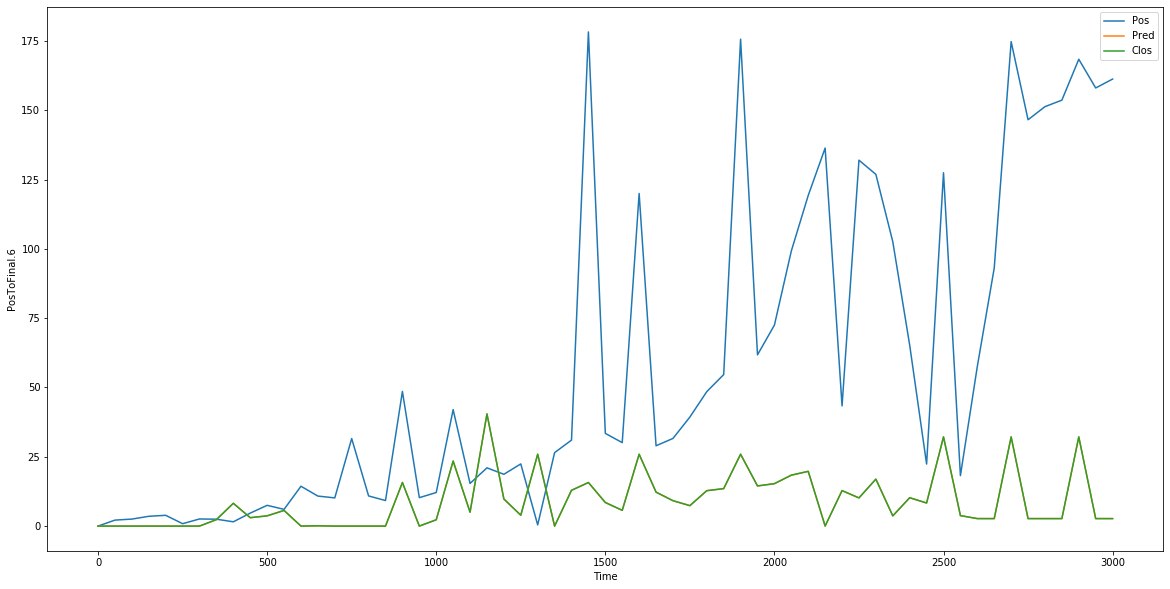

In [308]:
plt.figure(figsize = (20, 10))
sns.lineplot(x = 'Time' , y = 'PosToFinal.6', data = datafinal, label = 'Pos')
sns.lineplot(x = 'Time' , y = 'PredToFinal.6', data = datafinal, label = 'Pred')
sns.lineplot(x = 'Time' , y = 'ClosToFinal.6', data = datafinal, label = 'Clos')


In [ ]:
plt.figure(figsize = (20, 10))
sns.lineplot(x = 'Time' , y = 'PosToFinal.6', hue = 'Scale', data = datafinal, label = 'Pos')
sns.lineplot(x = 'Time' , y = 'PredToFinal.6', hue = 'Scale', data = datafinal, label = 'Pred')
sns.lineplot(x = 'Time' , y = 'ClosToFinal.6', hue = 'Scale', data = datafinal, label = 'Clos'#)

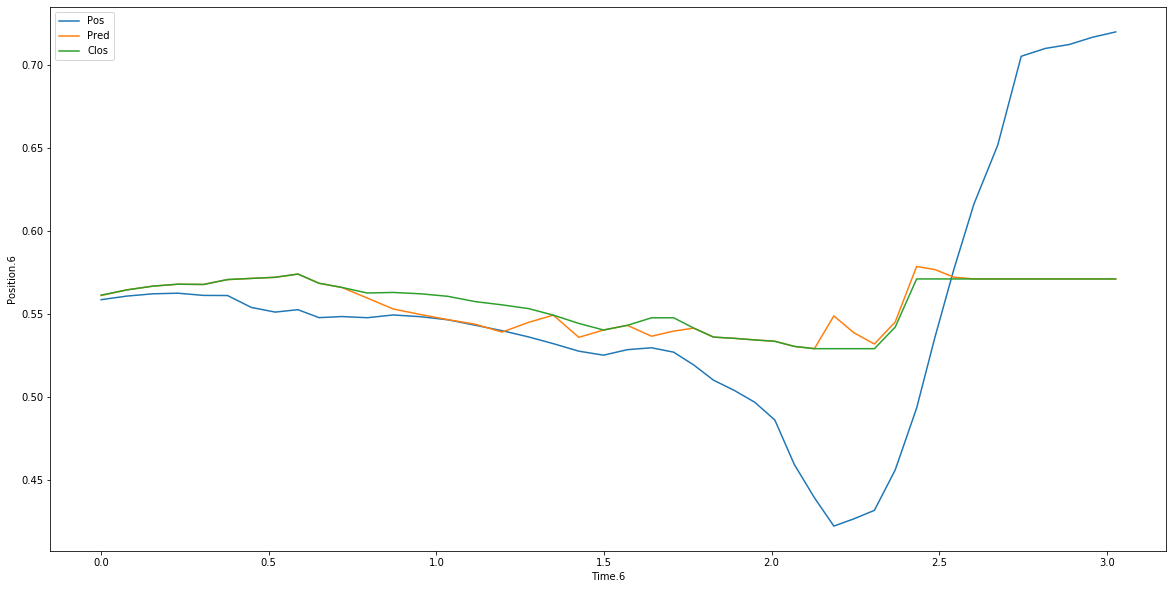

In [112]:
plt.figure(figsize = (20, 10))
sns.lineplot(x = 'Time.6' , y = 'Position.6', data = positionDf, label = 'Pos')
sns.lineplot(x = 'Time.6' , y = 'PosPred.6', data = positionDf, label = 'Pred')
sns.lineplot(x = 'Time.6' , y = 'ClosestPoint.6', data = positionDf, label = 'Clos')


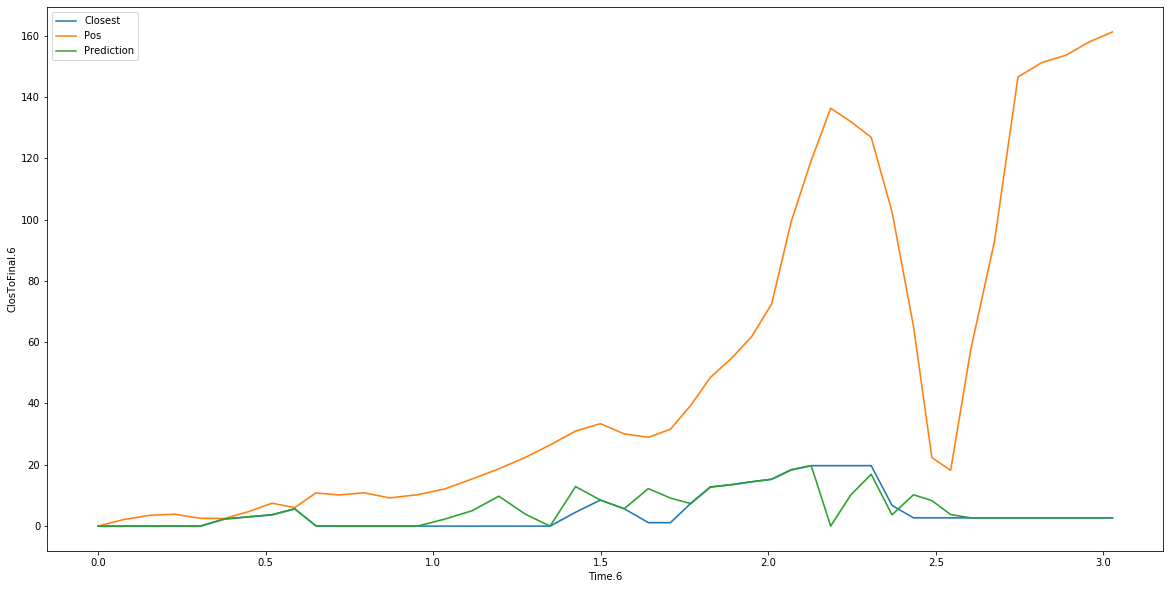

In [137]:
plt.figure(figsize = (20, 10))

conf = 134
sns.lineplot(x = 'Time.6' , y = 'ClosToFinal.6', data = summaryDifferences[summaryDifferences['Config'] == conf], label = 'Closest')
sns.lineplot(x = 'Time.6' , y = 'PosToFinal.6', data = summaryDifferences[summaryDifferences['Config'] == conf], label = 'Pos')#[summaryDifferences['Config'] == 3])
sns.lineplot(x = 'Time.6' , y = 'PredToFinal.6', data = summaryDifferences[summaryDifferences['Config'] == conf], label = 'Prediction')#[summaryDifferences['Config'] == 3])

#sns.lineplot(x = 'Time.6' , y = 'ClosToFinal.6', data = summaryDifferences, label = 'Clos')
#sns.lineplot(x = 'Time.6' , y = 'PosToFinal.6', data = summaryDifferences, label = 'Pos')
#sns.lineplot(x = 'Time.6' , y = 'PredToFinal.6', data = summaryDifferences, label = 'Pred')

In [170]:
summaryDifferences[(summaryDifferences['Config'] == conf) & (summaryDifferences['TimeInterval'] == 300)]

ClosToFinal.0  ClosToFinal.1  ClosToFinal.10  ClosToFinal.11  \
300            NaN            NaN             NaN             NaN   
300            NaN            NaN             NaN             NaN   
300            NaN            NaN             NaN             NaN   
300            NaN            NaN             NaN             NaN   
300            NaN            NaN             NaN             NaN   
300            NaN            NaN             NaN             NaN   
300            NaN            NaN             NaN             NaN   
300            NaN            NaN             NaN             NaN   
300            NaN            NaN             NaN             NaN   

     ClosToFinal.12  ClosToFinal.13  ClosToFinal.14  ClosToFinal.15  \
300             NaN             NaN             NaN             NaN   
300             NaN             NaN             NaN             NaN   
300             NaN             NaN             NaN             NaN   
300             NaN             NaN             NaN             NaN   
300             NaN             NaN             NaN             NaN   
300             NaN             NaN             NaN             NaN   
300             NaN             NaN             NaN             0.0   
300             NaN             NaN             NaN             0.0   
300             NaN             NaN             NaN             0.0   

     ClosToFinal.16  ClosToFinal.17  ...  Time.35  Time.36  Time.37  Time.4  \
300             NaN             NaN  ...      NaN      NaN      NaN     NaN   
300             NaN             NaN  ...      NaN      NaN      NaN     NaN   
300             NaN             NaN  ...      NaN      NaN      NaN     NaN   
300             NaN             NaN  ...      NaN      NaN      NaN     NaN   
300             NaN             NaN  ...      NaN      NaN      NaN     NaN   
300             NaN             NaN  ...      NaN      NaN      NaN     NaN   
300             NaN             NaN  ...      NaN      NaN      NaN     NaN   
300             NaN             NaN  ...      NaN      NaN      NaN     NaN   
300             NaN             NaN  ...      NaN      NaN      NaN     NaN   

     Time.5  Time.6  Time.7  Time.8  Time.9  TimeInterval  
300     NaN     NaN     NaN     NaN   0.293           300  
300     NaN     NaN     NaN     NaN   0.293           300  
300     NaN     NaN     NaN     NaN   0.293           300  
300     NaN     NaN     NaN     NaN   0.293           300  
300     NaN     NaN     NaN     NaN   0.293           300  
300     NaN     NaN     NaN     NaN   0.293           300  
300     NaN     NaN     NaN     NaN   0.293           300  
300     NaN     NaN     NaN     NaN   0.293           300  
300     NaN     NaN     NaN     NaN   0.293           300  

[9 rows x 230 columns]

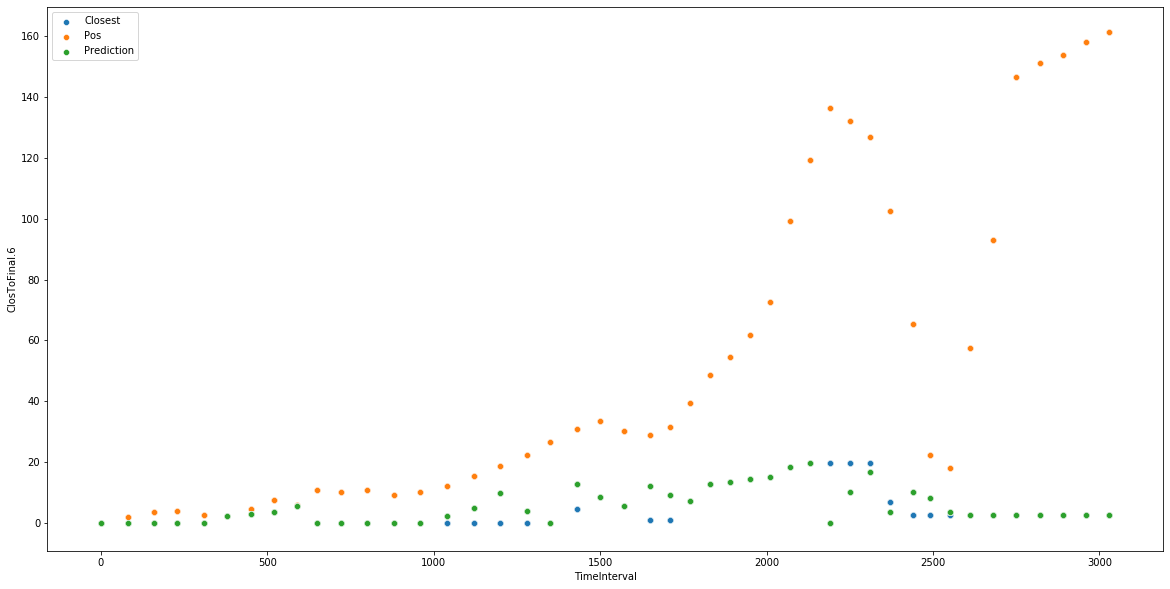

In [175]:
plt.figure(figsize = (20, 10))

conf = 134
sns.scatterplot(x = 'TimeInterval' , y = 'ClosToFinal.6', data = summaryDifferences[summaryDifferences['Config'] == conf], label = 'Closest')
sns.scatterplot(x = 'TimeInterval' , y = 'PosToFinal.6', data = summaryDifferences[summaryDifferences['Config'] == conf], label = 'Pos')#[summaryDifferences['Config'] == 3])
sns.scatterplot(x = 'TimeInterval' , y = 'PredToFinal.6', data = summaryDifferences[summaryDifferences['Config'] == conf], label = 'Prediction')#[summaryDifferences['Config'] == 3])


In [ ]:
meanDistInTol = pd.DataFrame()

for i in range(0, 135):
    for j in range(0, 38):
        k = 0
        if((analyseMe['Contact.'+str(j)].loc[i] == 'True') | (analyseMe['Contact.'+str(j)].loc[i] == '1.0')):
            nameBoneDist = 'Pos.'+str(j)+'.'+str(k)
            if(nameBoneDist in analyseMe.columns):
                meanDistInTol.loc[i, nameBoneDist] = analyseMe[nameBoneDist].loc[i]
            else:
                pass

            nameBonePred = 'PosPred.'+str(j)+'.'+str(k)
            if(nameBonePred in analyseMe.columns):
                meanDistInTol.loc[i, nameBonePred] = analyseMe[nameBonePred].loc[i]
            else:
                pass
            
            nameClos = 'ClosestPoint.'+str(j)+'.'+str(k)
            if(nameClos in analyseMe.columns):
                # if(analyseMe['MaxDistanceInTolTime.'+str(j)+'.'+str(k)].loc[i] > 0):
                meanDistInTol.loc[i, nameClos] = analyseMe[nameClos].loc[i]
                # else:
                #     pass
            else:
                pass 

        else:
            pass

        for k in range(100, 3050, 10):
            if((analyseMe['Contact.'+str(j)].loc[i] == 'True') | (analyseMe['Contact.'+str(j)].loc[i] == '1.0')):
                nameBoneDist = 'Pos.'+str(j)+'.'+str(k)
                if(nameBoneDist in analyseMe.columns):
                    meanDistInTol.loc[i, nameBoneDist] = analyseMe[nameBoneDist].loc[i]
                else:
                    pass

                nameBonePred = 'PosPred.'+str(j)+'.'+str(k)
                if(nameBonePred in analyseMe.columns):
                    meanDistInTol.loc[i, nameBonePred] = analyseMe[nameBonePred].loc[i]
                else:
                    pass

                nameClos = 'ClosestPoint.'+str(j)+'.'+str(k)
                if(nameClos in analyseMe.columns):
                    # if(analyseMe['MaxDistanceInTolTime.'+str(j)+'.'+str(k)].loc[i] > 0):
                    meanDistInTol.loc[i, nameClos] = analyseMe[nameClos].loc[i]
                    # else:
                    #     pass
                else:
                    pass 

            else:
                pass
            